In [1]:
# !ls /root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/images/val

In [2]:
# img_name = '000000384376.jpg'
# data_split = 'val'
img_name = '000000259376.jpg'
data_split = 'train'
# img_name = '000000042188.jpg'
# data_split = 'test'
camera_positions = ['A_Pillar_Driver', 'Rear_Mirror', 'A_Pillar_Codriver']
camera_position = camera_positions[2]
img_path = f'/root/synthetic_cabin_1m/syntheticcabin_1mil/processed_syntheticCabin_1m/{camera_position}/images/{data_split}/{img_name}'

In [3]:
from src.modules.human_detector.human_detector import HumanDetector

detector = HumanDetector(
    config_path='./src/modules/human_detector/config/faster_rcnn.py',
    pretrained_path='https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/'\
        'faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth',
    checkpoint_path="./mmengine_workdir/human_detector_synthetic_cabin_1m/epoch_1.pth",
    data_root_path='/root/synthetic_cabin_1m/syntheticcabin_1mil/processed_syntheticCabin_1m/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='./mmengine_workdir/human_detector_synthetic_cabin_1m',
    log_level='CRITICAL'
)

detector.load_pretrained()
detector_result = detector.get_bbox(img_path)
bbox = detector_result['bboxes']
print(bbox)

Loads checkpoint by local backend from path: ./mmengine_workdir/human_detector_synthetic_cabin_1m/epoch_1.pth
tensor([[ 661.4202,   33.4394, 1832.8845, 1080.0000]])


/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:757: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:828: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


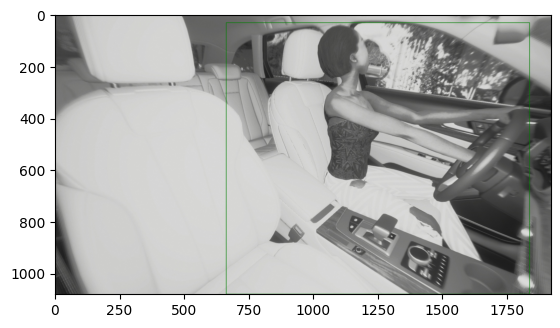

In [4]:
detector.visualise(img_path, bbox)

In [5]:
from src.modules.pose_estimator_2d.pose_estimator_2d import PoseEstimator2D

pose_estimator_2d = PoseEstimator2D(
    config_path='src/modules/pose_estimator_2d/config/hrnet.py',
    pretrained_path='https://download.openmmlab.com/mmpose/v1' \
        '/body_2d_keypoint/topdown_heatmap/coco' \
            '/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth',
    checkpoint_path="./mmengine_workdir/pose_estimator_2d_synthetic_cabin_1m/best_coco_AP_epoch_1.pth",
    data_root_path='/root/synthetic_cabin_1m/syntheticcabin_1mil/processed_syntheticCabin_1m/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='./mmengine_workdir/pose_estimator_2d_synthetic_cabin_1m',
    log_level='INFO'
)

pose_estimator_2d.load_pretrained()
pose_estimator_2d_result = pose_estimator_2d.inference(img_path, bbox.detach().cpu().numpy(), bbox_format='xywh')
keypoints_2D = pose_estimator_2d_result[0].pred_instances['keypoints'][0]
print(keypoints_2D)

11/16 15:07:02 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]
    CUDA available: False
    numpy_random_seed: 1790115153
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -Wno-deprecated -fvisibility-inlines-h

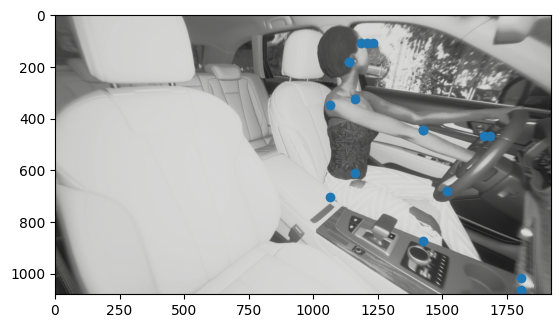

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

keypoints = pd.DataFrame(keypoints_2D, columns=['x', 'y'])

img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.scatter(keypoints['x'], keypoints['y'])
plt.show()

In [7]:
import json
import numpy as np
with open(f'/root/synthetic_cabin_1m/syntheticcabin_1mil/processed_syntheticCabin_1m/{camera_position}/annotations/person_keypoints_{data_split}.json') as f:
    
    data = json.loads(f.readline())

annotations = {}
for id in range(len(data['images'])):
    annotations[data['images'][id]['file_name']] = {
        'keypoints': np.array(data['annotations'][id]['keypoints']).reshape(-1, 3)[:, :2]
    }

11/16 15:07:10 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:680: UserWarning: Warning: The circle is out of bounds, the drawn circle may not be in the image
  warnings.warn(


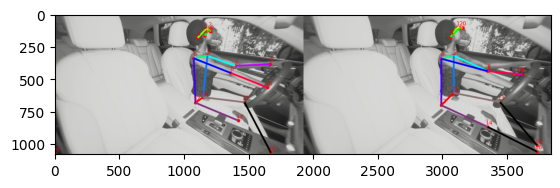

In [8]:
pose_estimator_2d.visualize(
    img_path=img_path,
    bboxes=bbox.tolist(),
    bbox_format='xywh',
    gt_keypoints=np.expand_dims(annotations[img_name]['keypoints'], 0)
)